# Run Experiments

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
from skimage import feature, exposure
import colorsys
import os
import random
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
import torchvision.models as models
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision import transforms
from pytorch_model_summary import summary

In [2]:
from utils import *
from HOG_and_DAISY_feature_extraction_methods import *

## Split the data into Train (and Validation) and a Test set

In [3]:
# # load all 30 classes, 220 images per class
# X, Y, idx_to_cl = load_dataset('data', cl_limit=30, img_limit=220)

# # train test split at 80-20 ratio
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, shuffle=True, random_state=42)

# print(f"Data shape: {X.shape}")
# print(f"Data labels shape: {Y.shape}\n")
# print(f"X Train shape: {X_train.shape}")
# print(f"Y Train shape: {Y_train.shape}")
# print(f"X Test shape: {X_test.shape}")
# print(f"Y Test shape: {Y_test.shape}")

# # save all as np
# folder_path = Path('train_test_split')
# folder_path.mkdir(parents=True, exist_ok=True)

# with open(folder_path / 'X_train.npy', 'wb') as f:
#     np.save(f, X_train)
# with open(folder_path / 'X_test.npy', 'wb') as f:
#     np.save(f, X_test)
# with open(folder_path / 'Y_train.npy', 'wb') as f:
#     np.save(f, Y_train)
# with open(folder_path / 'Y_test.npy', 'wb') as f:
#     np.save(f, Y_test)

In [4]:
# load in train and test data
folder_path = Path('train_test_split')

X_train = np.load(folder_path / 'X_train.npy')
Y_train = np.load(folder_path / 'Y_train.npy')
X_test = np.load(folder_path / 'X_test.npy')
Y_test = np.load(folder_path / 'Y_test.npy')

print(f"X Train shape: {X_train.shape}")
print(f"Y Train shape: {Y_train.shape}")
print(f"X Test shape: {X_test.shape}")
print(f"Y Test shape: {Y_test.shape}")

X Train shape: (5280, 600, 600, 3)
Y Train shape: (5280,)
X Test shape: (1320, 600, 600, 3)
Y Test shape: (1320,)


In [5]:
def process_features():
    """ """
    features, features_idxs = apply_features(X=X_train, feature_functions = {
        'temp': extract_small_brightness_hog_features,
    })
    
    # save features
    feature_folder_path = Path('features')

    with open(feature_folder_path / 'train_small_brightness_HOG_features.npy', 'wb') as f:
        np.save(f, features)
        
# process_features()

## Plan
 - PCA variance explained
    - load in all features 
    - plot variance explained together
 - Pick a final feature set
    - do PCA
    - do t-SNE

In [6]:
def load_features():
    """ """
    feature_dict = {}
    features_dir = Path('features')
    for path in Path('features').iterdir():
        feature_name = path.stem
        feature_data = np.load(path)
        feature_dict[feature_name] = feature_data
    return feature_dict

In [7]:
feature_dict = load_features()

In [ ]:
# features scaling
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(multiple_features) # replace input with whatever experiments we are doing
# TODO: save this scaler for final features only

In [ ]:
# PCA for features, use 95% explained variance for now
pca = PCA(n_components=0.95)
train_transformed = pca.fit_transform(features_train_scaled)
print(train_transformed.shape)

# TODO: save this pca model for final features

In [33]:
def get_PCA(X_list, n_components=2):
    pca_list = []
    xpca_list = []
    for X in X_list:
        pca = PCA(n_components=n_components).fit(X)
        X_pca = pca.transform(X)
        pca_list.append(pca)
        xpca_list.append(X_pca)
    return pca_list, xpca_list

def plot_PCA(X_list, labels, n_components=2):
    pca_list, xpca_list = get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    #colors = ['b-', 'm-', 'k-']
    for i in range(len(X_list)):
        # plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=labels[i])
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), label=labels[i])
    plt.yticks(np.linspace(0, 1, 8))
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.savefig(r"c:\Users\grays\Repositories\281 Computer Vision\w281-final\plots\ResNet_EffNet_PCA_explained_200.png")
    plt.show()

def get_tsne(X_list, n_components=2):
    xtsne_list = []
    for X in X_list:
        tsne = TSNE(n_components=n_components, random_state=0)
        X_tsne = tsne.fit_transform(X)
        xtsne_list.append(X_tsne)
    return xtsne_list

In [34]:
# feature_dict
feature_labels_list = []
feature_data_list = []
for feature_name in list(feature_dict.keys()):
    if feature_name == "train_HSV_features":
        continue
    elif feature_name == "train_RGB_features":
        continue
    else:
        feature_labels_list.append(feature_name)
        scalar = StandardScaler()
        features_scaled = scalar.fit_transform(feature_dict[feature_name])
        feature_data_list.append(features_scaled)
        
len(feature_labels_list), len(feature_data_list)

(20, 20)

In [36]:
feature_labels_list

['train_daisy_blue_features',
 'train_daisy_gray_features',
 'train_daisy_green_features',
 'train_daisy_red_features',
 'train_EffNet_features',
 'train_large_blue_HOG_features',
 'train_large_brightness_HOG_features',
 'train_large_gray_HOG_features',
 'train_large_green_HOG_features',
 'train_large_hue_HOG_features',
 'train_large_red_HOG_features',
 'train_large_saturation_HOG_features',
 'train_ResNet_features',
 'train_small_blue_HOG_features',
 'train_small_brightness_HOG_features',
 'train_small_gray_HOG_features',
 'train_small_green_HOG_features',
 'train_small_hue_HOG_features',
 'train_small_red_HOG_features',
 'train_small_saturation_HOG_features']

In [37]:
new_labels_list = [
    'DAISY (Blue)',
    'daisy (Grayscale)',
    'daisy (Green)',
    'daisy (Red)',
    'EfficientNet',
    'HOG (Large, Blue)',
    'HOG (Large, Brightness)',
    'HOG (Large, Grayscale)',
    'HOG (Large, Green)',
    'HOG (Large, Hue)',
    'HOG (Large, Red)',
    'HOG (Large Saturation)',
    'ResNet101',
    'HOG (Small, Blue)',
    'HOG (Small, Brightness)',
    'HOG (Small, Grayscale)',
    'HOG (Small, Green)',
    'HOG (Small, Hue)',
    'HOG (Small, Red)',
    'HOG (Small, Saturation)'
]

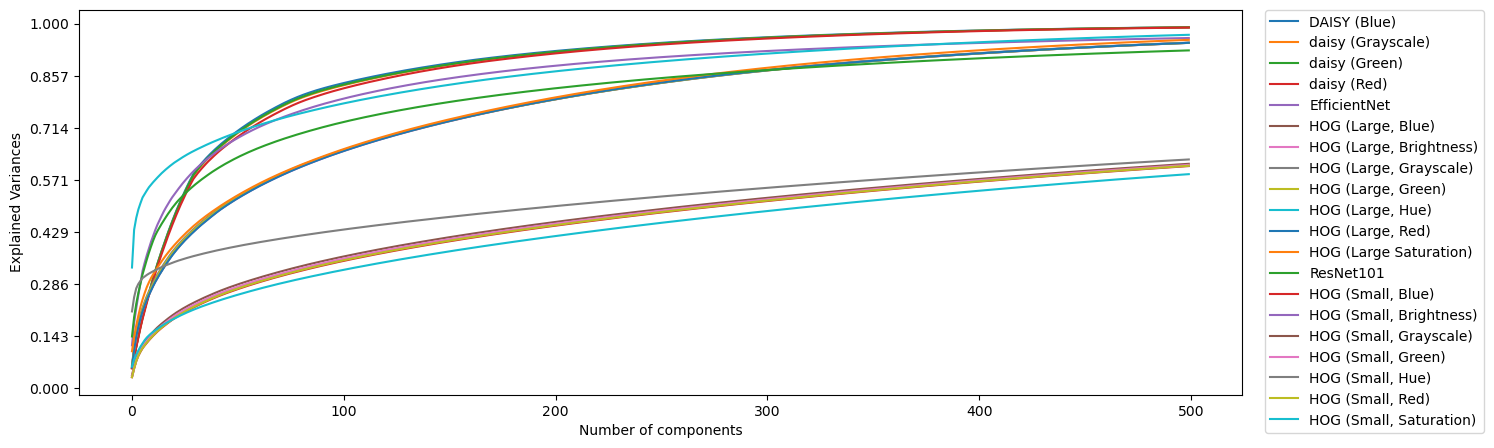

In [38]:
x = plot_PCA(X_list=feature_data_list, labels=new_labels_list, n_components=500)